# Neutrino flux from reactors

In this notebook, we calculate the total neutrino flux of reactor electron antineutrinos.

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

We use the Huber-Mueller model for reactor antineutrino fluxes. More specifically, we employ:

* The Huber model, from the inversion method of ILL, for U235, Pu239, and Pu241;
* The Mueller model, from ab initio summation method, for U238.

The implementation of the Huber model follows [the machine-readable files](https://www1.phys.vt.edu/~pahuber/reactorfluxes/) published by Huber, using a 250 keV binning from 2MeV to 8MeV and linear interpolation. The implementation of the Mueller model uses the following parametrization:

$$
s(E_{\nu}) = \mathrm{exp} \left( \sum_{p=1}^{6} \alpha_{p} E_{\nu}^{p-1} \right),
$$

and the parameters taken from arXiv:1101.2663v3.

In [ ]:
def get_isotope_flux(isotope):
    """
    Get the anti-neutrino flux function for a given isotope.

    Parameters:
    ----------
    isotope : str
        Isotope name, one of 'U235', 'U238', 'Pu239', 'Pu241'.

    Returns:
    -------
    flux_func : function
        A function that takes neutrino energy (MeV) as input and returns the flux (per fission per MeV).
    """
    assert isotope in [
        "U235",
        "U238",
        "Pu239",
        "Pu241",
    ], "Isotope must be one of U235, U238, Pu239, Pu241"
    if isotope == "U238":
        # Use Mueller model
        coefficients = [4.833e-1, 1.927e-1, -1.283e-1, -6.762e-3, 2.233e-3, -1.536e-4]

        def flux_func(E_nu):
            E_nu = np.atleast_1d(E_nu)
            return np.exp(
                np.sum(
                    [coefficients[i] * E_nu ** (i) for i in range(len(coefficients))],
                    axis=0,
                )
            )

        return flux_func
    else:
        # Use Huber model
        spectrum = np.loadtxt(
            f"./data/{isotope}-anti-neutrino-flux-250keV.dat", skiprows=19
        )
        flux_interp = scipy.interpolate.interp1d(
            spectrum[:, 0], spectrum[:, 1], kind="linear", fill_value="extrapolate"
        )
        # For energy larger than 8MeV, we extrapolate using the parameters given in the Huber paper
        coefficients_dict = {
            "U235": [4.367, -4.577, 2.100, -5.294e-1, 6.186e-2, -2.777e-3],
            "Pu239": [4.757, -5.392, 2.563, -6.596e-1, 7.820e-2, -3.536e-3],
            "Pu241": [2.990, -2.882, 1.278, -3.343e-1, 3.905e-2, -1.754e-3],
        }

        def flux_func(E_nu):
            E_nu = np.atleast_1d(E_nu)
            flux = flux_interp(E_nu)
            out_of_bounds = (E_nu < spectrum[0, 0]) | (E_nu > spectrum[-1, 0])
            flux[out_of_bounds] = np.exp(
                np.sum(
                    [
                        coefficients_dict[isotope][i] * E_nu[out_of_bounds] ** (i)
                        for i in range(len(coefficients_dict[isotope]))
                    ],
                    axis=0,
                )
            )
            return flux

        return flux_func

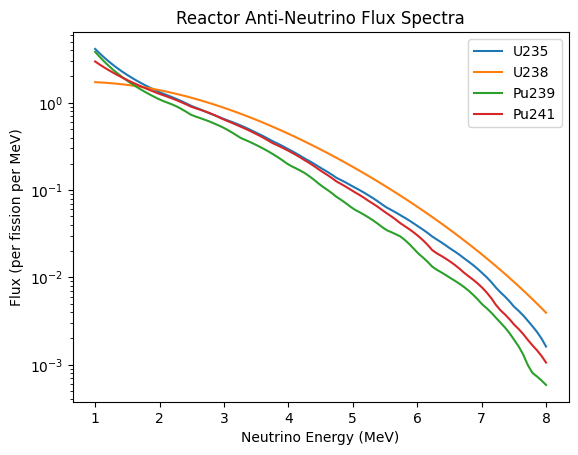

In [ ]:
test_energy = np.linspace(1, 8, 100)
plt.plot(test_energy, get_isotope_flux("U235")(test_energy), label="U235")
plt.plot(test_energy, get_isotope_flux("U238")(test_energy), label="U238")
plt.plot(test_energy, get_isotope_flux("Pu239")(test_energy), label="Pu239")
plt.plot(test_energy, get_isotope_flux("Pu241")(test_energy), label="Pu241")
plt.yscale("log")
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Flux (per fission per MeV)")
plt.title("Reactor Anti-Neutrino Flux Spectra")
plt.legend()
plt.show()

Next, sum up the contributions from different isotopes

$$
\Phi_r = \frac{1}{4\pi L_{i}^2}\frac{W_r}{\sum_{i}f_{ir}e_i} \sum_i f_{ir} s_{i} (E_{\nu})
$$

We also need to correct for the "reactor neutrino deficit", using the Daya-Bay flux ratio to the Huber-Mueller model.

In [ ]:
def one_reactor_unoscillated_flux(power_GW, distance_km):
    """
    Calculate the unoscillated neutrino flux from one reactor at a given distance.
    This calculation sums up contributions from U235, U238, Pu239, and Pu241, and
    scales the flux according to the Daya Bay scaling factor with respect to the
    Huber-Mueller model.

    Parameters:
    ----------
    power_GW : float
        Reactor thermal power in GW.
    distance_km : float
        Distance from the reactor to the detector in km.

    Returns:
    -------
    flux_func : function
        A function that takes neutrino energy (MeV) as input and returns the flux
        (per MeV per second per m^2).
    """
    # Reactor parameters
    fission_energies = {
        "U235": 202.36,  # in MeV
        "U238": 205.99,
        "Pu239": 211.12,
        "Pu241": 214.26,
    }
    fission_fractions = {"U235": 0.58, "U238": 0.07, "Pu239": 0.30, "Pu241": 0.05}

    # Calculate total fission rate (in fissions per second)
    total_fission_rate = (
        power_GW
        * 1e3
        / scipy.constants.e
        / sum(
            [
                fission_fractions[iso] * fission_energies[iso]
                for iso in fission_fractions
            ]
        )
    )

    # Get isotope flux functions (per fission per MeV)
    flux_funcs = {iso: get_isotope_flux(iso) for iso in fission_fractions}

    # Get scale factor from Daya Bay
    daya_bay_scale_factor = np.loadtxt("./data/daya_bay_flux_ratio.csv", delimiter=",")
    daya_bay_non_eq_corr = np.loadtxt("./data/daya_bay_non_eq_corr.csv", delimiter=",")
    daya_bay_spent_fuel_corr = np.loadtxt(
        "./data/daya_bay_spent_fuel_corr.csv", delimiter=","
    )

    def get_scale_factor(E_nu):
        # Note that this returns boundary values for out-of-bounds energies
        return (
            np.interp(E_nu, daya_bay_scale_factor[:, 0], daya_bay_scale_factor[:, 1])
            * (
                1
                + np.interp(
                    E_nu, daya_bay_non_eq_corr[:, 0], daya_bay_non_eq_corr[:, 1]
                )
            )
            * (
                1
                + np.interp(
                    E_nu, daya_bay_spent_fuel_corr[:, 0], daya_bay_spent_fuel_corr[:, 1]
                )
            )
        )

    def flux_func(E_nu):
        flux = np.zeros_like(E_nu)
        for iso in fission_fractions:
            flux += fission_fractions[iso] * flux_funcs[iso](E_nu)
        # Convert to per m^2 per second at given distance
        flux *= (
            total_fission_rate
            * get_scale_factor(E_nu)
            / (4 * np.pi * (distance_km * 1e3) ** 2)
        )
        return flux

    return flux_func

Sum up all reactors, and obtain the oscillated flux at the JUNO detector:

In [5]:
from neutrino_survival import NeutrinoSurvival

ns = NeutrinoSurvival()
reactor_data = {
    "Taishan_core1": [4.6, 52.71],
    "Taishan_core2": [4.6, 52.64],
    "Yangjiang_core1": [2.9, 52.74],
    "Yangjiang_core2": [2.9, 52.82],
    "Yangjiang_core3": [2.9, 52.41],
    "Yangjiang_core4": [2.9, 52.49],
    "Yangjiang_core5": [2.9, 52.11],
    "Yangjiang_core6": [2.9, 52.19],
    "DayaBay": [17.4, 215.0],
}


def all_reactors_unoscillated_flux(reactor_data):
    """
    Calculate the total unoscillated neutrino flux from all reactors listed in the data file.

    Parameters:
    ----------
    reactor_data : dict
        A dictionary where keys are reactor names and values are lists of [power_GW, distance_km].

    Returns:
    -------
    flux_func : function
        A function that takes neutrino energy (MeV) as input and returns the total flux
        (per MeV per second per m^2).
    """

    def total_flux_func(E_nu):
        total_flux = np.zeros_like(E_nu)
        for power, distance in reactor_data.values():
            total_flux += one_reactor_unoscillated_flux(power, distance)(E_nu)
        return total_flux

    return total_flux_func


def all_reactors_oscillated_flux(reactor_data, hierarchy="normal"):
    """
    Calculate the total oscillated neutrino flux from all reactors listed in the data file.

    Parameters:
    ----------
    reactor_data : dict
        A dictionary where keys are reactor names and values are lists of [power_GW, distance_km].
    hierarchy : str


    Returns:
    -------
    flux_func : function
        A function that takes neutrino energy (MeV) as input and returns the total flux
        (per MeV per second per m^2).
    """

    def total_flux_func(E_nu):
        total_flux = np.zeros_like(E_nu)
        for power, distance in reactor_data.values():
            total_flux += one_reactor_unoscillated_flux(power, distance)(
                E_nu
            ) * ns.survival_probability(E_nu, distance, hierarchy=hierarchy)
        return total_flux

    return total_flux_func

We plot the total oscillated flux as a function of neutrino energy.

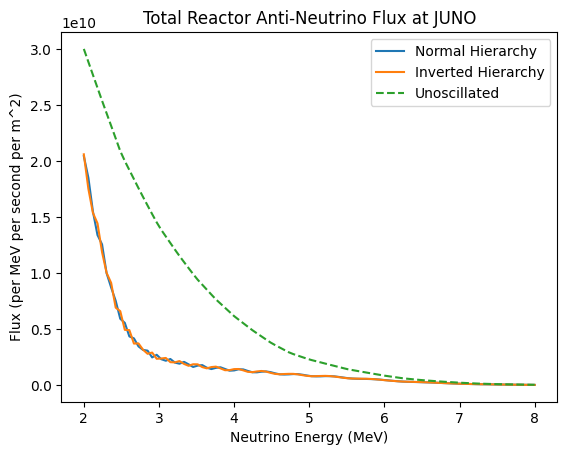

In [6]:
all_ractors_flux_normal = all_reactors_oscillated_flux(reactor_data, hierarchy="normal")
all_ractors_flux_inverted = all_reactors_oscillated_flux(
    reactor_data, hierarchy="inverted"
)
all_reactors_flux_unoscillated = all_reactors_unoscillated_flux(reactor_data)
test_energy = np.linspace(2, 8, 100)
plt.plot(test_energy, all_ractors_flux_normal(test_energy), label="Normal Hierarchy")
plt.plot(
    test_energy, all_ractors_flux_inverted(test_energy), label="Inverted Hierarchy"
)
plt.plot(
    test_energy,
    all_reactors_flux_unoscillated(test_energy),
    label="Unoscillated",
    linestyle="--",
)
# plt.yscale('log')
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Flux (per MeV per second per m^2)")
plt.title("Total Reactor Anti-Neutrino Flux at JUNO")
plt.legend()
plt.show()

Also, transform to the antineutrino spectra weighted by the IBD total cross section.

In [7]:
N_p = 1.44e33  # Number of free protons in JUNO detector
eff = 0.822  # Detection efficiency

from ibd_kinematics import StrumiaVissani


def expected_ibd_event_rate(flux_func):
    """
    Calculate the expected IBD event rate in JUNO detector given the neutrino flux function.

    Parameters:
    ----------
    flux_func : function
        A function that takes neutrino energy (MeV) as input and returns the flux
        (per MeV per second per m^2).

    Returns:
    -------
    event_rate : float
        The expected IBD event rate in the JUNO detector (events per second).
    """
    sv = StrumiaVissani()

    def rate(E_nu):
        E_nu = np.atleast_1d(E_nu)
        return (
            flux_func(E_nu) * sv.get_total_cross_section(E_nu) * 1e-4 * eff * N_p
        )  # Convert cm^2 to m^2

    return rate

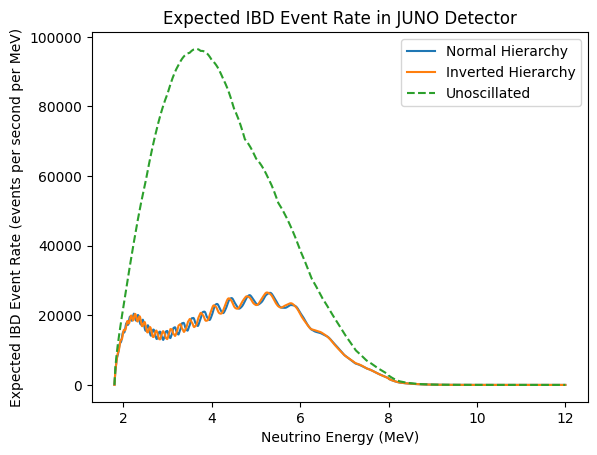

In [8]:
trial_nu_energies = np.linspace(1.8, 12.0, 1000)
plt.plot(
    trial_nu_energies,
    expected_ibd_event_rate(flux_func=all_ractors_flux_normal)(trial_nu_energies)
    * 86400
    * 365.25
    * 6,
    label="Normal Hierarchy",
)
plt.plot(
    trial_nu_energies,
    expected_ibd_event_rate(flux_func=all_ractors_flux_inverted)(trial_nu_energies)
    * 86400
    * 365.25
    * 6,
    label="Inverted Hierarchy",
)
plt.plot(
    trial_nu_energies,
    expected_ibd_event_rate(flux_func=all_reactors_flux_unoscillated)(trial_nu_energies)
    * 86400
    * 365.25
    * 6,
    label="Unoscillated",
    linestyle="--",
)
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Expected IBD Event Rate (events per second per MeV)")
plt.title("Expected IBD Event Rate in JUNO Detector")
plt.legend()
plt.show()

We calculate how many IBD events are expected:

In [9]:
# How many IBD events per year?
# Use Simpson's rule to integrate over neutrino energy
from scipy.integrate import simpson

E_nu_values = np.linspace(1.8, 12.0, 1000)
rate_normal = expected_ibd_event_rate(flux_func=all_ractors_flux_normal)(E_nu_values)
rate_inverted = expected_ibd_event_rate(flux_func=all_ractors_flux_inverted)(
    E_nu_values
)

total_rate_normal = simpson(rate_normal, E_nu_values)
total_rate_inverted = simpson(rate_inverted, E_nu_values)

print(
    f"Total expected IBD events per year (Normal Hierarchy): {total_rate_normal * 3600 * 24 * 365.25:.2e}"
)
print(
    f"Total expected IBD events per year (Inverted Hierarchy): {total_rate_inverted * 3600 * 24 * 365.25:.2e}"
)

Total expected IBD events per year (Normal Hierarchy): 1.71e+04
Total expected IBD events per year (Inverted Hierarchy): 1.71e+04


In [10]:
print(
    f"Total expected IBD events per day (Normal Hierarchy): {total_rate_normal * 3600 * 24:.2e}"
)
print(
    f"Total expected IBD events per day (Inverted Hierarchy): {total_rate_inverted * 3600 * 24:.2e}"
)

Total expected IBD events per day (Normal Hierarchy): 4.68e+01
Total expected IBD events per day (Inverted Hierarchy): 4.68e+01


Finally, we apply the detector response matrix, and check the normalization.

79665791
Response matrix loaded from juno_detector_response_matrix_79665791.npz


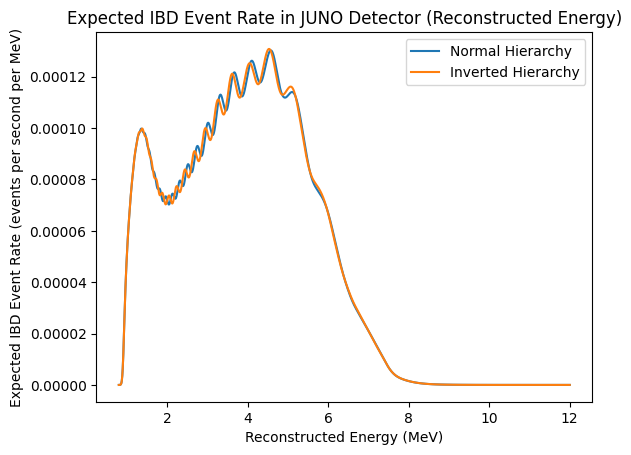

In [11]:
from detector_response import JUNODetector
from ibd_kinematics import StrumiaVissani

sv = StrumiaVissani()
juno_detector = JUNODetector(sv)
# print(juno_detector.stable_hash())

juno_detector.load_response_matrix()
E_nu_grid = np.linspace(1.8, 12.0, 3000)
E_rec_grid = np.linspace(0.8, 12.0, 3000)

rate_normal_grid = expected_ibd_event_rate(flux_func=all_ractors_flux_normal)(E_nu_grid)
rate_inverted_grid = expected_ibd_event_rate(flux_func=all_ractors_flux_inverted)(
    E_nu_grid
)
rate_normal_rec = juno_detector.apply_response_matrix(
    rate_normal_grid, E_nu_grid, E_rec_grid
)
rate_inverted_rec = juno_detector.apply_response_matrix(
    rate_inverted_grid, E_nu_grid, E_rec_grid
)

plt.plot(E_rec_grid, rate_normal_rec, label="Normal Hierarchy")
plt.plot(E_rec_grid, rate_inverted_rec, label="Inverted Hierarchy")
plt.xlabel("Reconstructed Energy (MeV)")
plt.ylabel("Expected IBD Event Rate (events per second per MeV)")
plt.title("Expected IBD Event Rate in JUNO Detector (Reconstructed Energy)")
plt.legend()

In [13]:
rate_normal_total = simpson(rate_normal_rec, E_rec_grid)
rate_inverted_total = simpson(rate_inverted_rec, E_rec_grid)

print(
    f"Total expected IBD events per day (Normal Hierarchy, Reconstructed): {rate_normal_total * 3600 * 24:.2e}"
)
print(
    f"Total expected IBD events per day (Inverted Hierarchy, Reconstructed): {rate_inverted_total * 3600 * 24:.2e}"
)

Total expected IBD events per day (Normal Hierarchy, Reconstructed): 4.68e+01
Total expected IBD events per day (Inverted Hierarchy, Reconstructed): 4.68e+01
